In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [5]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [6]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\BIOS\physicians_extracted.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_10796\756537171.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,hard_text,profession,gender,skills_extracted,education_extracted,countries_extracted,experience_years
0,"in addition to english, he speaks spanish. dr....",physician,male,[],[],[],NaN
1,"in his practice, he is particularly interested...",physician,male,[],[],[],NaN
2,"prior to this, he was a consultant anesthetist...",physician,male,[],[],"['anesthesia', 'obstetric', 'uk']",NaN
3,he has received a 4.0 out of 5 star rating by ...,physician,male,[],[],[],NaN
4,he studied medicine at philadelphia college of...,physician,male,[],[],[],NaN
...,...,...,...,...,...,...,...
195,"she practices in annapolis, maryland and has t...",physician,female,[],[],"['annapolis', 'maryland']",NaN
196,"ms. boone practices medicine in mesa, az and 1...",physician,female,[],[],[],NaN
197,"ms. losado practices medicine in mcallen, tx a...",physician,female,[],[],['mcallen'],NaN
198,"ms. weisenborn practices medicine in buffalo, ...",physician,female,[],[],['buffalo'],NaN


In [7]:

# Use only the 'hard_text' column for text input
texts = df["hard_text"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 200
["in addition to english, he speaks spanish. dr. capone's clinical interests include dermabrasion, breast augmentation, and labiaplasty. he is affiliated with upmc shadyside. he graduated from george washington university school of medicine and health sciences and georgetown university school of medicine and then he performed his residency at tufts medical center, children's hospital of pittsburgh, and upmc presbyterian. he has received a 4.0 out of 5 star rating by his patients. dr. capone is in-network for united healthcare platinum, united healthcare navigate, and coventry, in addition to other insurance carriers.", 'in his practice, he is particularly interested in refractive surgery (vision correction surgery) and cataracts. dr. lehmann is an in-network provider for blue cross/blue shield, blue cross blue shield bronze, and blue cross blue shield hmo, in addition to other insurance carriers. he attended medical school at medical college of wisconsin. his

In [8]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


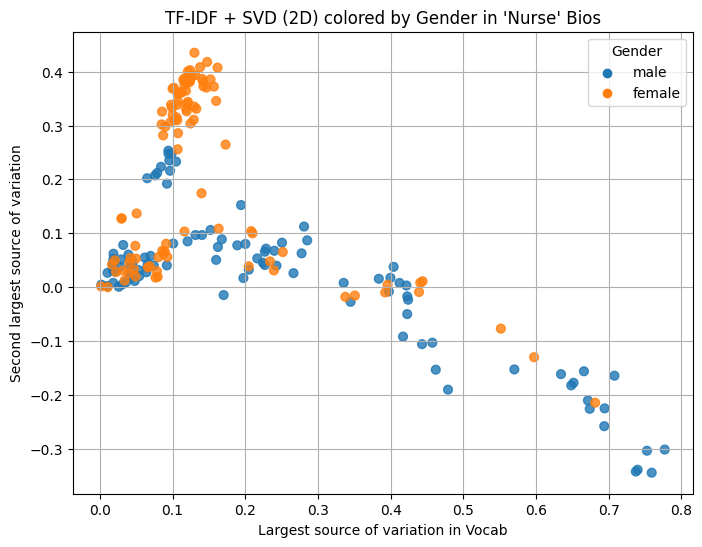

In [9]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in 'Nurse' Bios")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [10]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [11]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [12]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [13]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,blue,0.585582,-0.282816,male
1,shield,0.288619,-0.282686,male
2,cross,0.284301,-0.272008,male
3,dr,0.210861,-0.339547,male
4,medical,0.183913,0.042290,female
5,hospital,0.163501,0.068374,female
6,university,0.161574,-0.144686,male
7,insurance,0.134359,-0.259808,male
8,medicine,0.130745,0.286056,female
9,carriers,0.127689,-0.280984,male



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,ms,0.587496,0.616152,female
1,medicine,0.229759,0.286056,female
2,specializes,0.219422,0.474033,female
3,practices,0.210794,0.362500,female
4,center,0.176566,0.214012,female
5,english,0.176488,0.289720,female
6,speaks,0.171708,0.287585,female
7,hospital,0.171041,0.068374,female
8,affiliated,0.159870,0.154062,female
9,spanish,0.157598,0.318549,female


In [14]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
              word  coefficient predicted_gender
1137            ms     3.104658           Female
1577   specializes     0.762024           Female
360         center     0.599084           Female
647         family     0.545830           Female
1333     practices     0.520734           Female
1086      medicine     0.507315           Female
1571       spanish     0.494961           Female
1020      location     0.379405           Female
1154    neddenriep     0.362975           Female
125   affiliations     0.354646           Female
817        hopkins     0.344942           Female
1275    pediatrics     0.343447           Female
385        chinese     0.339658           Female
1066        master     0.334150           Female
1574        speaks     0.327143           Female
606        english     0.314026           Female
1509       science     0.310767           Female
929        johnson     0.300164           Female
854        include     0.295831    

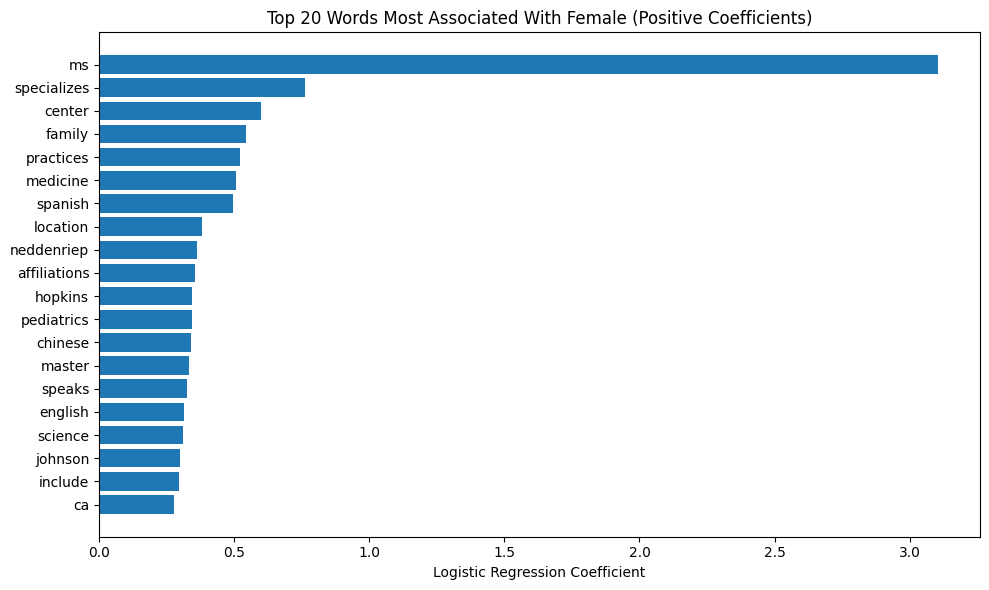

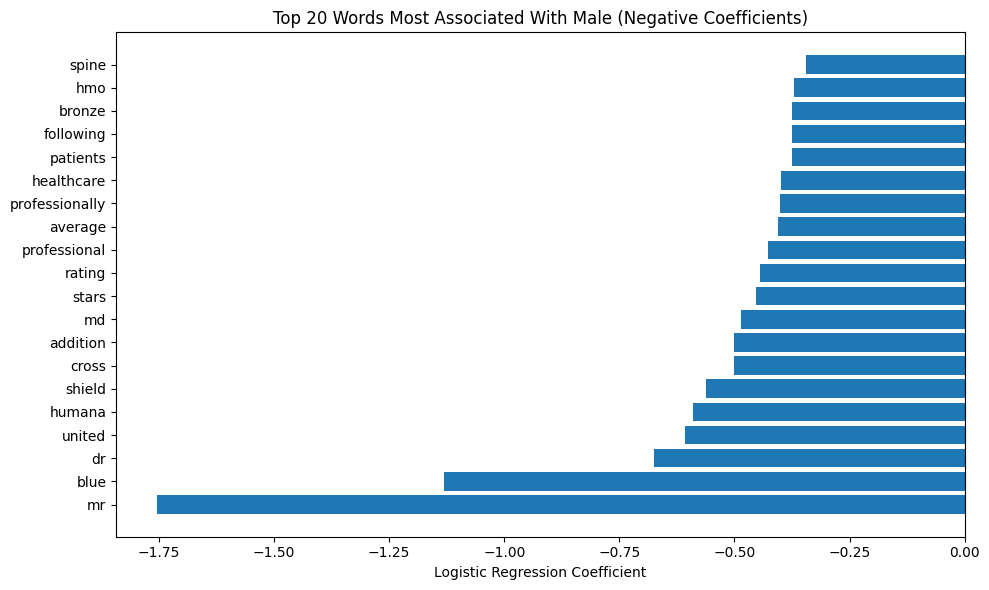

In [15]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


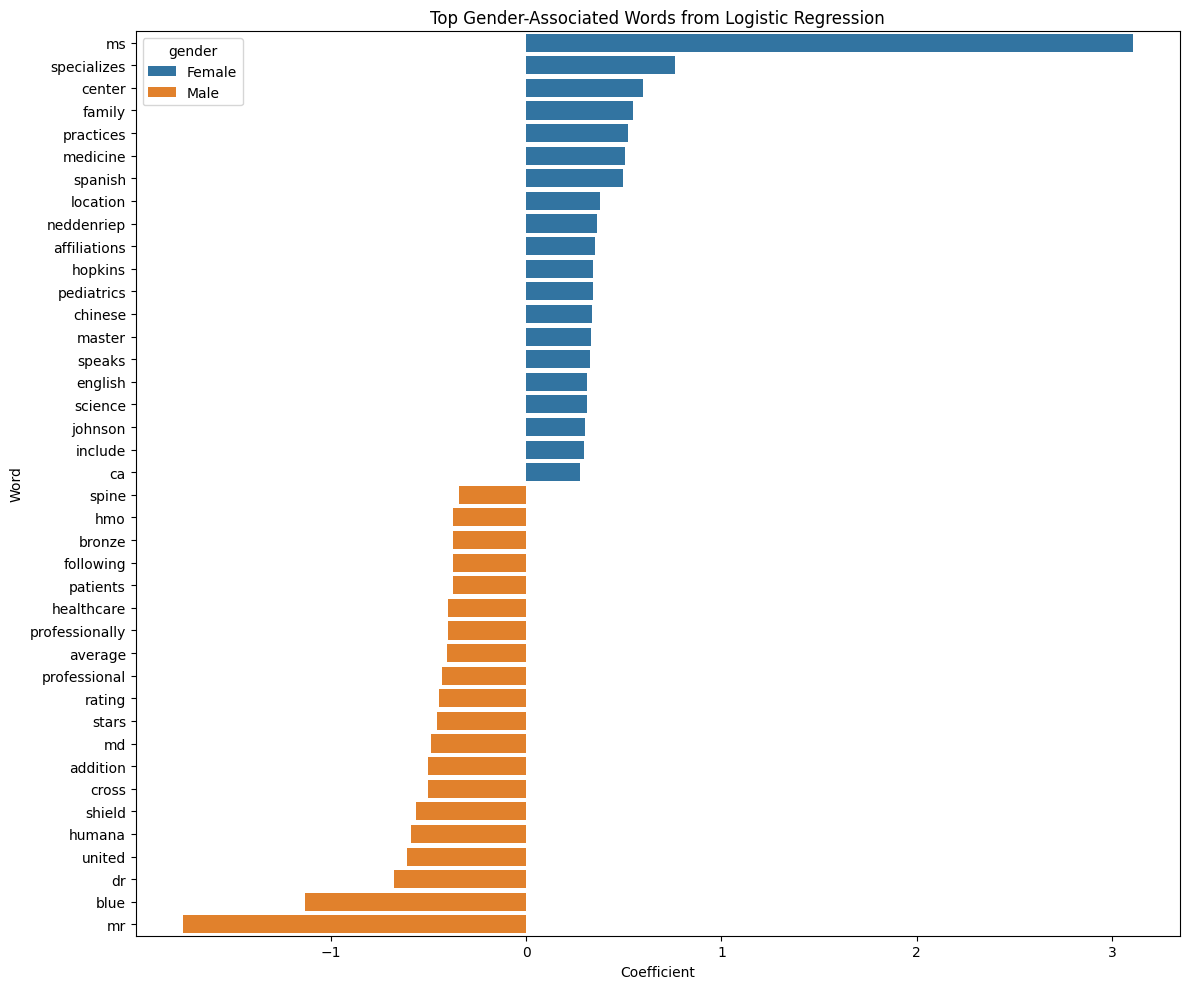

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = pd.concat([
    top_female_words.assign(gender="Female"),
    top_male_words.assign(gender="Male")
])

plt.figure(figsize=(12, 10))
sns.barplot(
    data=subset,
    y="word",
    x="coefficient",
    hue="gender",
    dodge=False
)
plt.title("Top Gender-Associated Words from Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


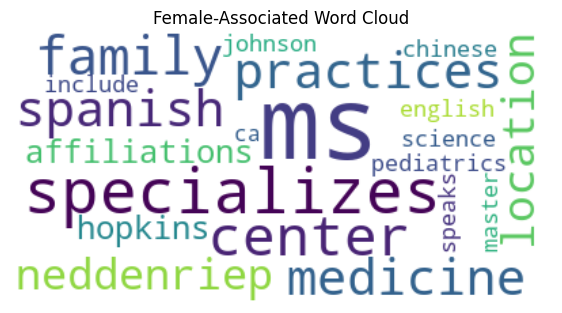

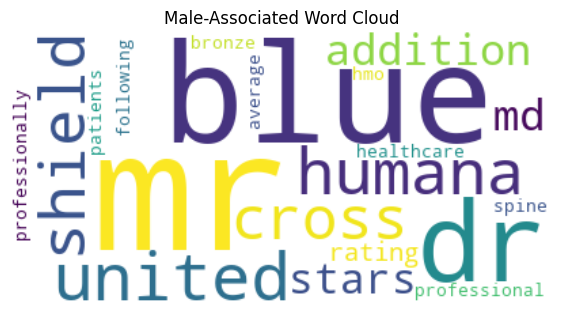

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

female_weights = {row.word: row.coefficient for _, row in top_female_words.iterrows()}
male_weights = {row.word: -row.coefficient for _, row in top_male_words.iterrows()}

# Female
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(female_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Female-Associated Word Cloud")
plt.show()

# Male
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(male_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Male-Associated Word Cloud")
plt.show()
